In [2]:
import pandas as pd

In [9]:
#df = pd.read_csv('/Users/ceaksan/Desktop/PageContentAnalysis/Python/Content/GA-2020-08-01.csv', header=0)
df = pd.read_csv('/Users/ceaksan/Desktop/PageContentAnalysis/Python/Forecasting/pageviews-new.csv', header=0, names=['ds','y'], delimiter=';')
holidays = pd.read_csv('/Users/ceaksan/Desktop/PageContentAnalysis/Python/Forecasting/holidays.csv', header=0, names=['ds'], delimiter=',')

In [10]:
holidays.head()

ds
0  2014-01-01
1  2014-04-23
2  2014-05-01
3  2014-05-19
4  2014-07-27

In [119]:
#print(df.head())
#print(df.tail())
#print(holidays.head())
#print(holidays.tail())

In [120]:
# df.loc[:, df.columns.isin(['ga:date','pageviews'])]
# df[['ga:date','pageviews']]
# df.drop(columns=df.iloc[:, df.columns.isin(['ga:date','pageviews'])==False], inplace=True)
# df.rename(columns={'ga:date': 'date'}, inplace=True)

In [14]:
# df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
df['ds'] = pd.to_datetime(df['ds'], format='%d.%m.%Y', errors='ignore')
# df = df.set_index('date')

df.drop(1307, axis=0, inplace=True) if df.shape[0] == 1308 else True
 
df.head()
df.tail()


ds      y
1302 2021-07-27  58519
1303 2021-07-28  59134
1304 2021-07-29  60600
1305 2021-07-30  57762
1306 2021-07-31  56816

In [15]:
df.shape

(1307, 2)

In [16]:
df.isna().any()

ds    False
y     False
dtype: bool

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 1306
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1307 non-null   datetime64[ns]
 1   y       1307 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 30.6 KB


In [18]:
# df_grouped = df.groupby('date').mean()
# df_grouped.head()
# df_pg = df[['date', 'pageviews', 'sessions']]
df.describe()

y
count   1307.000000
mean   27200.494262
std    17122.890352
min      993.000000
25%    11824.000000
50%    24451.000000
75%    44630.500000
max    65125.000000

In [19]:
# missing_dates = pd.date_range(start=df_pg.index.min(), end=df_pg.index.max()).difference(df.index)
missing_dates = pd.date_range(start=df['ds'].min(), end=df['ds'].max()).difference(df['ds'])
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [20]:
# !pip install prophet
# !pip install seaborn

from prophet import Prophet
import matplotlib.pyplot as plt

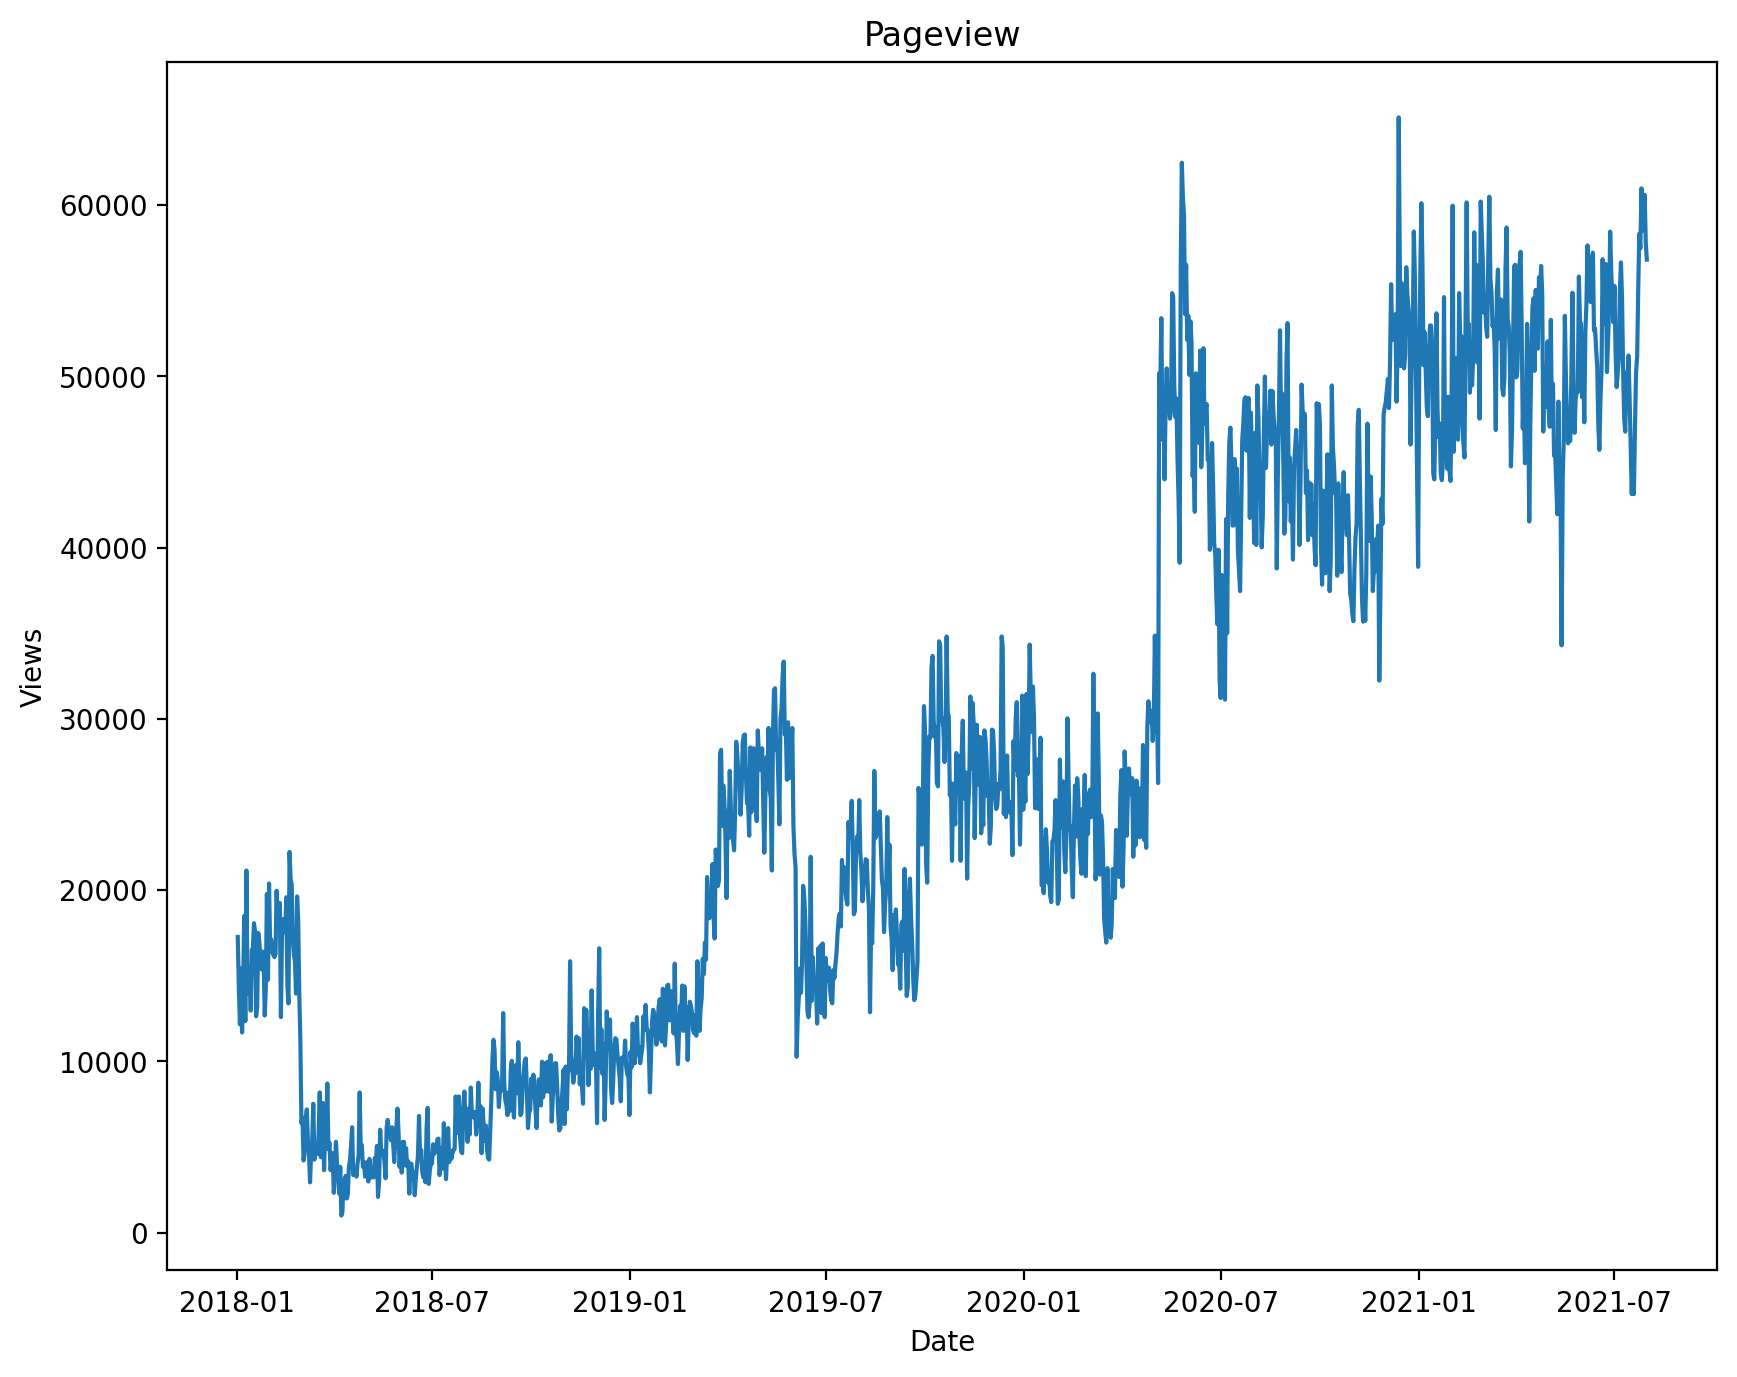

In [22]:
plt.figure(figsize=(10, 8), dpi=200)
plt.plot(df['ds'], df['y'])
plt.title('Pageview')
plt.xlabel('Date')
plt.ylabel('Views')
plt.show()

<AxesSubplot:xlabel='ds'>

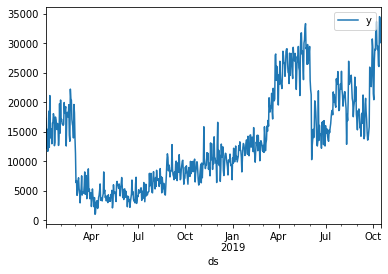

In [23]:
#df.query("ds > '01-06-2020' and ds < '01-02-2021'").agg('mean')
df.query("ds < ds.mean()").plot(x='ds', y='y')

<AxesSubplot:xlabel='ds'>

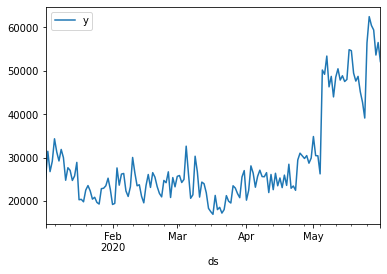

In [24]:
#df.query("ds > '01-01-2020' and ds < '01-06-2020'").agg('mean')
df.query("ds > '01-01-2020' and ds < '06-01-2020'").plot(x='ds', y='y')

In [26]:
df['year'] = df['ds'].dt.year

In [28]:
holiday = pd.DataFrame({
  'ds': holidays['ds'],
  'holiday': 'start',
  'lower_window': 0,
  'upper_window': 2,
})

#df['y'] = 10 - df['y']
#df['cap'] = 6
#df['floor'] = 1.5

# m = Prophet()

m = Prophet(yearly_seasonality=True,
seasonality_prior_scale=5,
holidays=holiday,
holidays_prior_scale=5,
changepoint_prior_scale=1)

# daily_seasonality = False, weekly_seasonality = True, seasonality_mode='multiplicative', growth = 'logistic'
m.add_country_holidays(country_name='TR')

m.train_holiday_names

m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -26.8915
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2725.2      0.124684       376.636           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2836.87     0.0205805       406.127           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2979.52     0.0192192       308.456           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2993.82        0.0591       289.744           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          3017     0.0692847       377.479      0.5052           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [29]:
m.train_holiday_names

0                                       start
1                              New Year's Day
2     National Sovereignty and Children's Day
3                                  Labour Day
4                    Commemoration of Ataturk
5                        Youth and Sports Day
6            Democracy and National Unity Day
7                                 Victory Day
8                                Republic Day
9                               Ramadan Feast
10                      Ramadan Feast Holiday
11                            Sacrifice Feast
12                    Sacrifice Feast Holiday
dtype: object

In [30]:
future = m.make_future_dataframe(periods=6, freq='M')
#future['cap'] = 6
#future['floor'] = 1.5
future.tail()

ds
1308 2021-09-30
1309 2021-10-31
1310 2021-11-30
1311 2021-12-31
1312 2022-01-31

In [32]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower     yhat_upper
1308 2021-09-30  64341.529366  54495.329208   74276.081504
1309 2021-10-31  67588.826391  45035.207190   88551.339576
1310 2021-11-30  74625.745171  39001.222684  108209.838968
1311 2021-12-31  78199.843779  26763.693259  124195.551030
1312 2022-01-31  79812.363896  13176.546558  141414.998619

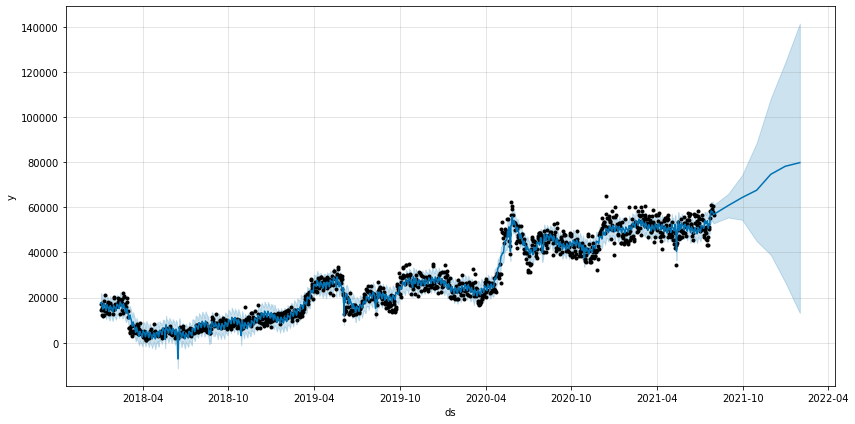

In [33]:
fig1 = m.plot(forecast, figsize=(12, 6))

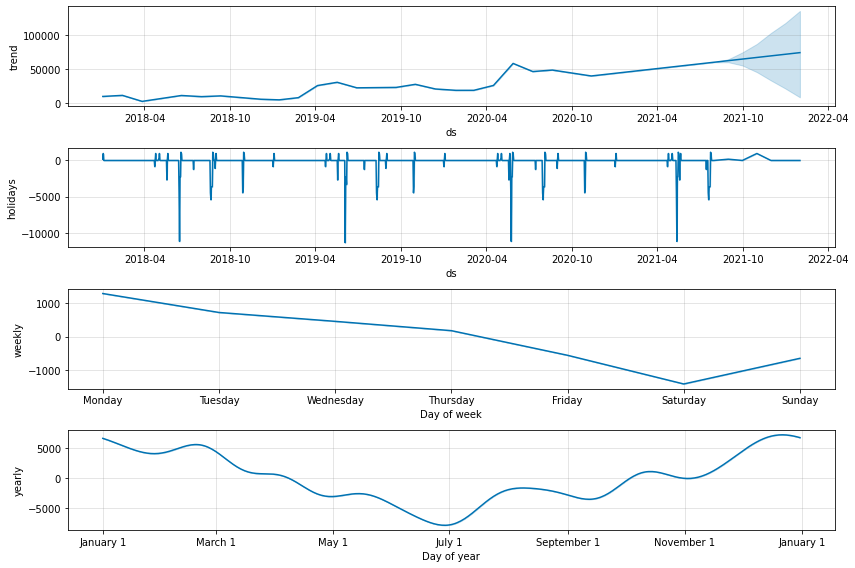

In [34]:
fig2 = m.plot_components(forecast, weekly_start=1, figsize=(12, 8))

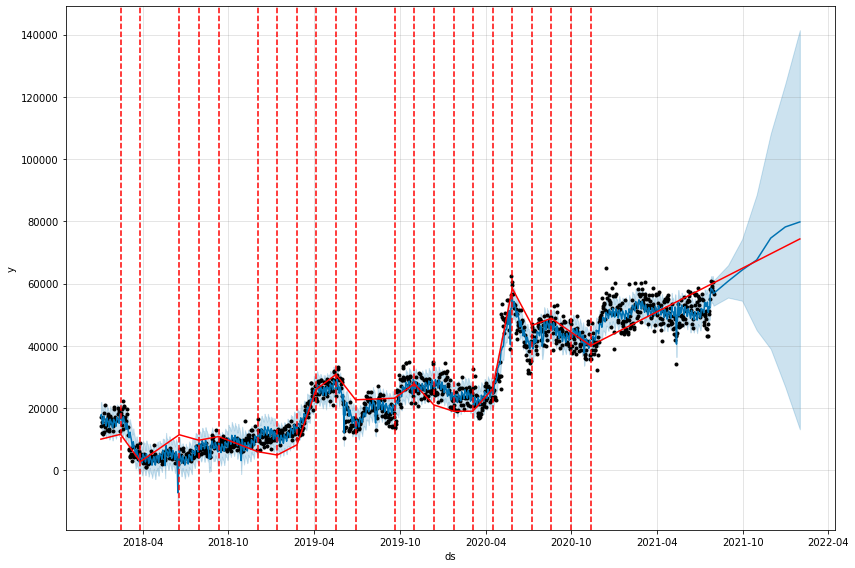

In [35]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast, figsize=(12, 8))
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [36]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [37]:
plot_components_plotly(m, forecast)

In [38]:
model = Prophet(seasonality_mode='multiplicative')
# model = Prophet(changepoint_prior_scale=0.5, changepoint_range=0.9, seasonality_mode='multiplicative', yearly_seasonality = 10)
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -26.8915


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2567.4     0.0156686       171.909           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2595.95    0.00371273       220.107           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2599.4     0.0117478       94.6533           1           1      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       2600.79   0.000221535       81.2933   1.748e-06       0.001      508  LS failed, Hessian reset 
     399        2601.3    0.00259368       71.3189           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     475       2602.81   0.000257151       63.5804   3.853e-06       0.001      6

In [39]:
future = model.make_future_dataframe(periods= 60)
#future['cap'] = 30
#future['floor'] = 0
print(future.tail())

             ds
1362 2021-09-25
1363 2021-09-26
1364 2021-09-27
1365 2021-09-28
1366 2021-09-29


In [40]:
holiday = pd.DataFrame({
  'ds': holidays['ds'],
  'holiday': 'start',
  'lower_window': 0,
  'upper_window': 2,
})

In [41]:
holiday.head()

ds holiday  lower_window  upper_window
0  2014-01-01   start             0             2
1  2014-04-23   start             0             2
2  2014-05-01   start             0             2
3  2014-05-19   start             0             2
4  2014-07-27   start             0             2

In [42]:
fbp = Prophet(holidays=holiday)
fbp.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -26.8915
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2569.56      0.014028       341.997      0.1223           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2605.33     0.0108172       169.509           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       2610.24   0.000339758       130.609   2.177e-06       0.001      357  LS failed, Hessian reset 
     299       2611.28    0.00173012       85.5912           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371        2612.9   0.000369075       95.3316   5.397e-06       0.001      520  LS failed, Hessian reset 
     399       2613.02   0.000359547       66.4625      0.5244      0.5244      554   
    Iter      log pro

In [47]:
df_forecast = fbp.make_future_dataframe(periods=365, freq='D')
df_forecast2 = fbp.predict(df_forecast)

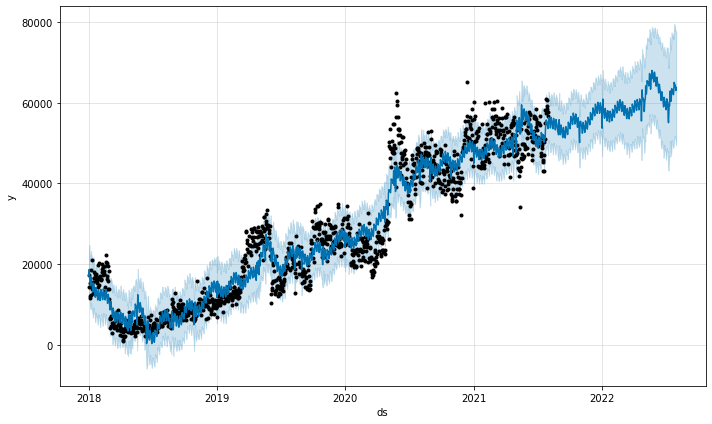

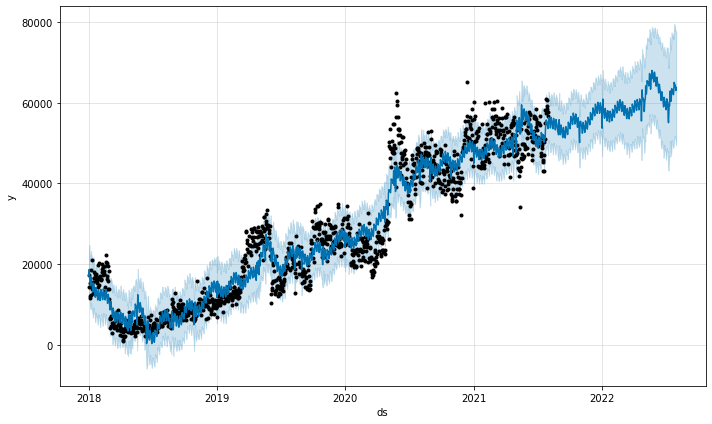

In [51]:
fbp.plot(df_forecast2)

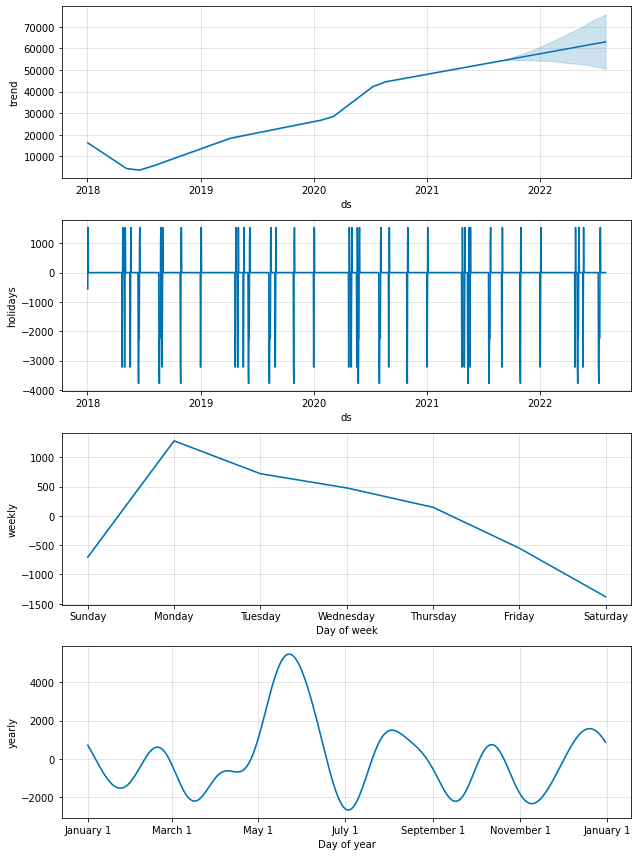

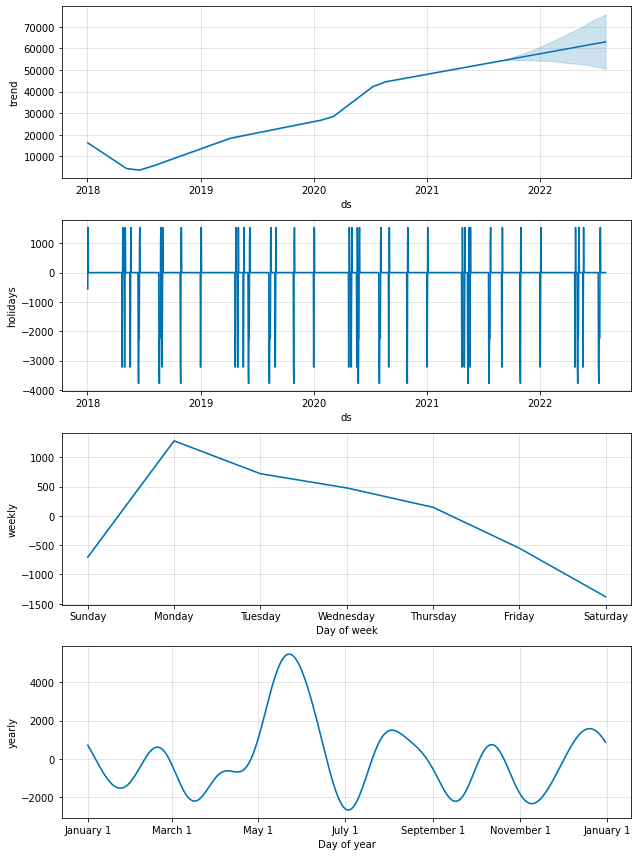

In [49]:
fbp.plot_components(df_forecast2)

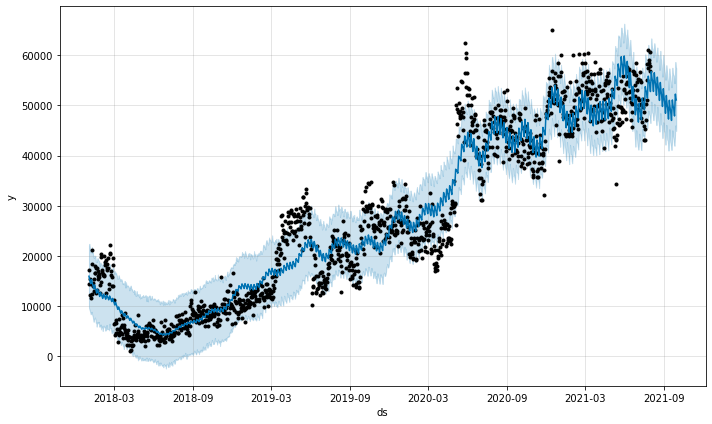

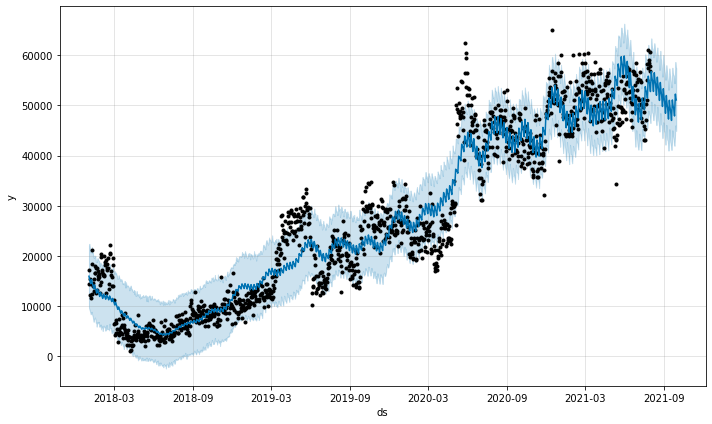

In [52]:
forecast = model.predict(future)
model.plot(forecast)

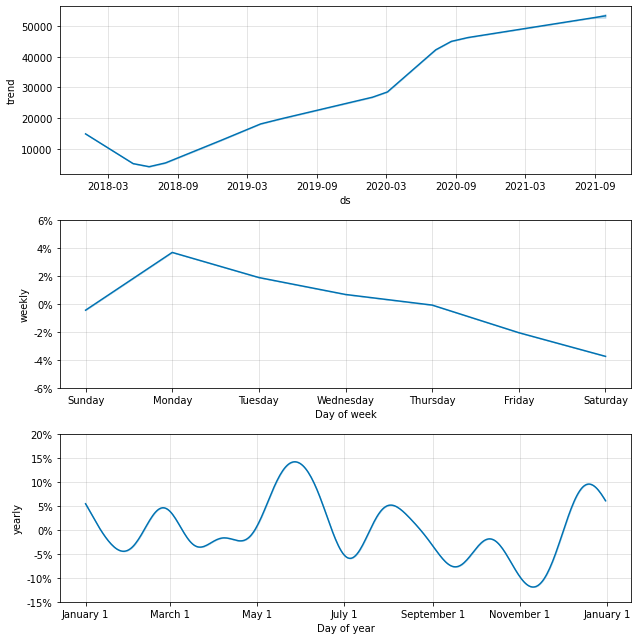

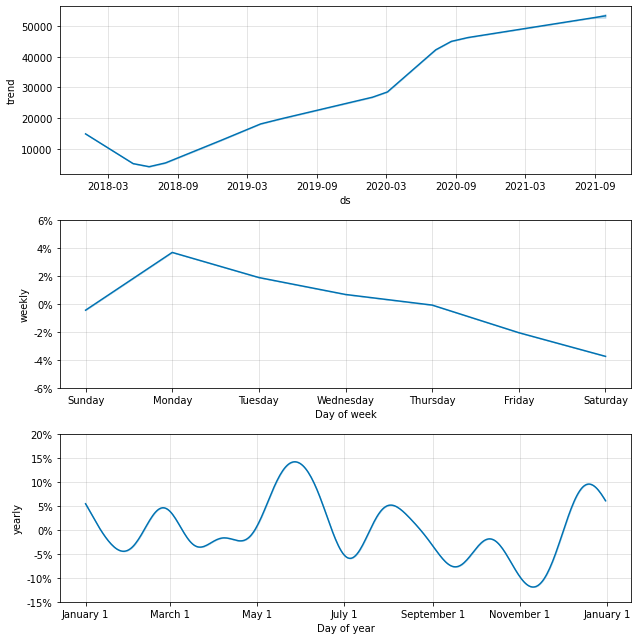

In [53]:
model.plot_components(forecast)

In [54]:
future = m.make_future_dataframe(periods=6, freq='M')
#future['cap'] = 6
#future['floor'] = 1.5
future.tail()

ds
1308 2021-09-30
1309 2021-10-31
1310 2021-11-30
1311 2021-12-31
1312 2022-01-31

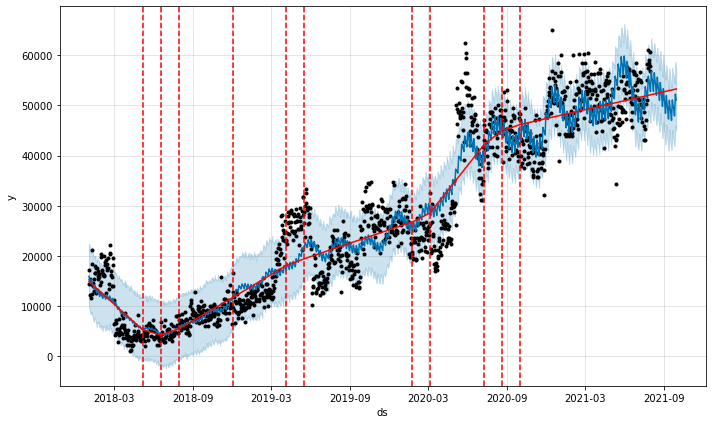

In [55]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [41]:
# from fbprophet.diagnostics import cross_validation
# df_cv = cross_validation(model, horizon = 7, initial = 30, parallel='processes')
# df_cv = cross_validation(model, initial = 30, period = 30, horizon = 30, parallel='processes')
# df_cv.head()